In [47]:
'''
steps to detect book lines or shelf lines:

1. Blur: remove noise 
Smoothing, also called blurring, is a simple and frequently used image processing operation.
To perform a smoothing operation we will apply a filter to our image. 
The most common type of filters are linear, gaussian, median, etc
https://docs.opencv.org/3.4/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html
2. Sobel X/Y: Sobel edge detector is a gradient based method based on the first order derivatives. 
It calculates the first derivatives of the image separately for the X and Y axes.
https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php
3. Downsample: effectively reduces image size and resolution
4. Standardize: mean subtraction per channel was used to center the data around 
zero mean for each channel (R, G, B). This typically helps any operation
act uniformly for each channel
5. Binarize: 
6. Erode:
It erodes away the boundaries of foreground objects. 
It is used to remove small white noises from the images. 
Erosion can also be used to detach two connected images.
- A kernel is formed from an image. The kernel is a matrix,
where the order is odd, like 3, 5, 7.
- A pixel of image is chosen. This pixel will be chosen as 1 only if 
all the pixels under the kernel is 1. Otherwise it will be eroded.
- So all pixels near the boundary will be discarded.
- So the thickness of foreground object decreases.
https://www.tutorialspoint.com/erosion-and-dilation-of-images-using-opencv-in-python
https://docs.opencv.org/2.4/doc/tutorials/imgproc/erosion_dilatation/erosion_dilatation.html
7. Dilate:
It increases the object area. The Erosion can remove the white noises, 
but it also shrinks our image, so after Erosion, 
if Dilation is performed, we can get better noise removal results. 
- A kernel is formed from an image. The kernel is a matrix, 
where the order is odd, like 3, 5, 7.
- A pixel of image is chosen. This pixel will be chosen as 1 only 
if all the pixels under the kernel is 1.
- Increases the white region or the size of foreground objects of the image.
https://docs.opencv.org/2.4/doc/tutorials/imgproc/erosion_dilatation/erosion_dilatation.html
8. Connect components: computes the connected components labeled image of boolean image
9. Remove short clusters: remove short vertical lines.
10. Upsample: restore the image to the correct overall size that it was before a
downsample was used in the imag eprocessing pipeline.

'''


import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import scipy.ndimage
import scipy.stats
import numpy as np
import cv2
import os
import csv
from PIL import Image
import pytesseract


%matplotlib inline


class Line(object):
    '''
    Simple class that holds the information related to a line;
    i.e., the slope, y-intercept, and center point along the line
    '''

    vertical_threshold = 30

    def __init__(self, m, b, center, min_x, max_x, min_y, max_y):
        '''
        m: slope
        b: y-intercept
        center: center point along the line (tuple)
        '''

        self.m = m
        self.b = b

        self.center = center

        self.min_x = min_x
        self.max_x = max_x

        self.min_y = min_y
        self.max_y = max_y
        
    def __repr__(self):
        return F'line slope is {self.m},line intercept is {self.b},line center\
        is {self.center},line min_x is {self.min_x},line max_x is {self.max_x},\
        line min_y is {self.min_y},line max_y is {self.max_y}'

    def y(self, x):
        '''
        Returns the y-value of the line at position x.
        If the line is vertical (i.e., slope is close to infinity), the y-value
        will be returned as None
        '''

        # Line is vertical
        if self.m > self.vertical_threshold:
            return None

        else:
            return self.m * x + self.b

    def x(self, y):
        '''
        Returns the x-value of the line at posiion y.
        If the line is vertical (i.e., slope is close to infinity), will always
        return the center point of the line
        '''

        # Line is vertical
        if self.m > self.vertical_threshold:
            return self.center[0]

        # Line is not vertical
        else:
            return (y - self.b) / self.m


def plot_img(img, show=True):

    fig = plt.figure(figsize=(16, 12))
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    if show:
        plt.show()


def gaussian_blur(img, sigma, debug=False):
    '''
    Blurs the image with a gaussian kernel of length sigma.
    This is usually done before line detection is performed to remove noise
    '''

    proc_img = scipy.ndimage.filters.gaussian_filter(img, sigma=(sigma, sigma))

    if debug:
        print('gaussian blur')
        plot_img(proc_img, show=True)

    return proc_img


def downsample(img, num_downsamples, debug=False):
    '''
    Downsamples an image by 50% num_downsamples times.
    This effectively reduces image size and resolution.
    '''

    proc_img = np.copy(img)
    for i in range(num_downsamples):
        proc_img = scipy.ndimage.interpolation.zoom(proc_img, .5)

        if debug:
            print('downsample', i)
            plot_img(proc_img, show=True)

    return proc_img


def sobel_x_squared(img, debug=False):
    '''
    Calculates the sobel_x transformation (x-gradient) squared.
    '''

    proc_img = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=-1)**2.

    if debug:
        print('sobel x')
        plot_img(proc_img)

    return proc_img


def sobel_y_squared(img, debug=False):
    '''
    Calculates the sobel_x transformation (y-gradient) squared.
    '''

    proc_img = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=-1)**2.

    if debug:
        print('sobel x')
        plot_img(proc_img)

    return proc_img


def standardize(img, debug=False):
    '''
    Standardizes the image via img = (img - min/(max-min), where max and min
    are the maxima and minima pixel intensities present in the image
    '''
    proc_img = (img - np.min(img)) / (np.max(img) - np.min(img))

    if debug:
        print('standardize')
        plot_img(proc_img)

    return proc_img


def digitize(img, num_levels, debug=False):
    '''
    Digitizes the image by binning the pixel intensities.
    '''

    img_max = np.max(img)
    img_min = np.min(img)
    bins = [1. * i * (img_max - img_min) /
            num_levels for i in range(0, num_levels)]
    proc_img = np.digitize(img, bins)

    if debug:
        print('digitize')
        plot_img(proc_img, show=True)

    return proc_img


def binarize(img, cutoff, debug=False):
    '''
    Binarizes an image by setting intensity of any pixel value with intensity
    not equal to zero to equal one.
    Final image has pixel intensities [0,1].
    '''

    img[img > cutoff] = 1
    img[img <= cutoff] = 0

    if debug:
        print('binarize')
        plot_img(img, show=True)

    return img


def dynamic_binarize(img, cutoff, debug=False):
    '''
    Binarizes an image by setting intensity of any pixel value with intensity
    not equal to zero to equal one.
    Final image has pixel intensities [0,1].
    '''

    if debug:
        print('dynamic binarize (before)')
        plt.hist(img.flatten())
        plt.show()

    for i in range(20):
        cutoff = i * .01
        bright_pixel_ratio = len(np.where(img > cutoff)[
                                 0]) / (img.shape[0] * img.shape[1])

        if bright_pixel_ratio <= 0.4:
            break

    img[img > cutoff] = 1
    img[img <= cutoff] = 0

    if debug:
        print('dynamic binarize')

        plot_img(img, show=True)

    return img


def vertical_erode(img, structure_length, iterations, debug=False):
    '''
    Erodes the image with a vertical structure element of length structure_length.
    Used to get rid of lines that are primarily horizontal.
    '''

    structure = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]) * structure_length
    proc_img = scipy.ndimage.morphology.binary_erosion(
        img, structure, iterations)

    if debug:
        print('vertical erode')
        plot_img(proc_img, show=True)

    return proc_img


def vertical_dilate(img, structure_length, iterations, debug=False):
    '''
    Dilates an image in the vertical direction using a vertical structure element
    of scale structure_length.
    This is used to connect lines that are close by vertically.
    Repeats iterations times.
    '''

    structure = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]) * structure_length
    proc_img = scipy.ndimage.morphology.binary_dilation(
        img, structure, iterations)

    if debug:
        print('vertical dilate')
        plot_img(proc_img, show=True)

    return proc_img


def dilate(img, structure_length, iterations, debug=False):
    '''
    Dilates an image in the vertical direction using a vertical structure element
    of scale structure_length.
    This is used to connect lines that are close by vertically.
    Repeats iterations times.
    '''

    structure = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) * structure_length
    proc_img = scipy.ndimage.morphology.binary_dilation(
        img, structure, iterations)

    if debug:
        print('dilate')
        plot_img(proc_img, show=True)

    return proc_img


def horizontal_erode(img, structure_length, iterations, debug=False):
    '''
    Erodes the image with a horizontal structure element of length structure_length.
    Used to prevent lines that are close horizontally from clustering
    '''

    structure = np.array([[0, 0, 0], [0, 1, 1], [0, 0, 0]]) * structure_length
    proc_img = scipy.ndimage.morphology.binary_erosion(
        img, structure, iterations)

    if debug:
        print('horizontal erode')
        plot_img(proc_img, show=True)

    return proc_img


def horizontal_erode_dilate(img, structure_length, iterations, debug=False):
    '''
    Erodes the image with a horizontal structure element of length structure_length.
    Used to prevent lines that are close horizontally from clustering
    '''

    structure = np.array([[0, 0, 0], [0, 1, 1], [0, 0, 0]]) * structure_length
    proc_img = scipy.ndimage.morphology.binary_erosion(
        img, structure, iterations)
    proc_img = scipy.ndimage.morphology.binary_dilation(
        proc_img, structure, iterations)

    if debug:
        print('horizontal erode/dilate')
        plot_img(proc_img, show=True)

    return proc_img


def connected_components(img, debug=False):
    '''
    Finds all connected components in a binary image and assigns all connections
    within a component to a unique value for that component.
    Returns the processed image, and the values of the unique components.
    '''
    proc_img, levels = scipy.ndimage.label(img, structure=np.ones((3, 3)))
    levels = list(range(1, levels + 1))

    if debug:
        print('find connected components, levels = ', levels)
        plot_img(proc_img, show=True)

    return proc_img, levels


def remove_short_clusters_vertical(img, levels, threshold_fraction, debug=False):
    '''
    Given an image that has been labeled with connected components (see above),
    calculates the vertical height of each component and filters those that
    are too short.
    The threshold should be set as a fraction of the longest line present in the
    image.
    This is used to remove short vertical lines.
    '''

    drop_values = []
    ptps = []

    # Calculate peak-to-peak height of line
    for level in levels:
        bright_pixels = np.where(img == level)
        ptp = np.ptp(bright_pixels[0])
        ptps.append(ptp)

    # Determine which lines to drop
    threshold = np.max(ptps) / 2.
    for i in range(len(ptps)):
        if ptps[i] < threshold:
            drop_values.append(levels[i])

    # Drop the lines
    for drop_value in drop_values:
        img[img == drop_value] = 0

    if debug:
        print('remove short clusters')
        plt.hist(ptps, bins=25)
        plt.show()
        plot_img(img, show=True)

    return img


def remove_short_clusters_horizontal(img, levels, threshold_fraction, debug=False):
    '''
    Given an image that has been labeled with connected components (see above),
    calculates the vertical height of each component and filters those that
    are too short.
    The threshold should be set as a fraction of the longest line present in the
    image.
    This is used to remove short vertical lines.
    '''

    drop_values = []
    ptps = []

    # Calculate peak-to-peak height of line
    for level in levels:
        bright_pixels = np.where(img == level)
        ptp = np.ptp(bright_pixels[1])
        ptps.append(ptp)

    # Determine which lines to drop
    threshold = np.max(ptps) / 2.
    for i in range(len(ptps)):
        if ptps[i] < threshold:
            drop_values.append(levels[i])

    # Drop the lines
    for drop_value in drop_values:
        img[img == drop_value] = 0

    if debug:
        print('remove short clusters')
        plt.hist(ptps, bins=25)
        plt.show()
        plot_img(img, show=True)

    return img


def upsample(img, upsample_factor, debug=False):
    '''
    Upsamples the image, e.g. multiplies its height and width by the upsample_factor.
    This is performed to restore the image to the correct overall size that it
    was before a downsample was used in the imag eprocessing pipeline.
    '''

    proc_img = img.repeat(upsample_factor, axis=0).repeat(
        upsample_factor, axis=1)

    if debug:
        print('upsample')
        plot_img(proc_img, show=True)

    return proc_img


def invert(img, debug=False):
    '''
    Inverts a binary image
    '''

    proc_img = 1 - img

    if debug:
        print('invert')
        plot_img(proc_img, show=True)

    return proc_img


def get_lines_from_img(img, levels, debug=False):
    '''
    Finds the equations for all of the lines in a binary image,
    and returns as a list of Line objects (see above class definition).
    '''

    lines = []
    for level in levels:
        line = np.where(img == level)
        xs = line[1]
        ys = line[0]
        center = [np.mean(xs), np.mean(ys)]

        min_x = np.min(xs)
        max_x = np.max(xs)
        min_y = np.min(ys)
        max_y = np.max(ys)

        #print('std ratio', np.std(ys)/np.std(xs))
        spread = (np.max(ys) - np.min(ys)) / (np.max(xs) - np.min(xs))

        # Line is vertical
        # if (np.std(ys)/np.std(xs) > 10):
        if spread > 10:
            line = Line(1000, 0, center, min_x, max_x, min_y, max_y)

        # Line is not vertical
        else:
            m, b, r, p, std = scipy.stats.linregress(xs, ys)
            line = Line(m, b, center, min_x, max_x, min_y, max_y)

        lines.append(line)

    # Sort the lines by their center x positions
    lines.sort(key=lambda line: line.center[0])

    return lines


def laplace_squared(img, debug=False):
    '''
    '''
    # Laplacian (sqrt)
    sobel_x_img = sobel_x_squared(img)
    sobel_y_img = sobel_y_squared(img)
    proc_img = (sobel_x_img**2. + sobel_y_img**2.)**.5

    if debug:
        print('laplace squared')
        plot_img(proc_img)

    return proc_img


            
def get_shelf_lines(img, debug=False):

    proc_img = np.mean(img, axis=2)
    
    # Blur
    sigma = 3
    proc_img = gaussian_blur(proc_img, sigma=sigma, debug=debug)

    # Down sample
    num_downsamples = 3
    proc_img = downsample(proc_img, num_downsamples, debug=debug)

    # Sobel y
    proc_img = laplace_squared(proc_img, debug=debug)

    # Standardize
    proc_img = standardize(proc_img, debug=debug)

    # Binarize
    cutoff = np.max(proc_img) / 500.
    proc_img = binarize(proc_img, cutoff, debug=debug)

    # Vertical dilate
    structure_length = 200
    iterations = 1
    proc_img = vertical_dilate(
        proc_img, structure_length, iterations, debug=debug)

    # Horizontal erode
    structure_length = 200
    iterations = 50
    proc_img = horizontal_erode(
        proc_img, structure_length, iterations, debug=debug)

    # Connected components
    proc_img, levels = connected_components(proc_img, debug=debug)

    # Remove short clusters
    threshold_fraction = 0.10
    proc_img = remove_short_clusters_horizontal(
        proc_img, levels, threshold_fraction, debug=debug)

    # Up sample
    upsample_factor = 2**num_downsamples
    proc_img = upsample(proc_img, upsample_factor, debug=debug)

    # Connected components
    proc_img, levels = connected_components(proc_img, debug=debug)

    # Lines
    lines = get_lines_from_img(proc_img, levels, debug=False)

    # Plot the result
    if debug:

        new_img = np.copy(img[:, :, ::-1])

        plot_img(new_img, show=False)
        for line in lines:
            y0 = 0
            y1 = np.shape(img)[0]

            x0 = line.x(y0)
            x1 = line.x(y1)

            plt.plot([x0, x1], [y0, y1], color='yellow', lw=3)

        plt.xlim(0, img.shape[1])
        plt.ylim(img.shape[0], 0)
        plt.xticks([])
        plt.yticks([])
        plt.savefig('proc_img.png', bbox_inches='tight', dpi=300)

        plt.show()

    return lines

def distance_of_lines(lines):
    ''' 
    Takes a list of ordered lines and computes the distance between the left most line's center'''
    
    distance_btwn_lines = []
    for order, line in enumerate(lines):
        line_x_cent, line_y_cent = line.center
        if line != lines[-1]:
            if lines[order+1].x(line_y_cent):
                distance_btwn_lines.append((lines[order+1].x(line_y_cent) - line.center[0]))
    return (distance_btwn_lines)

def distance_between_two_lines(line_one, line_two):
    '''
    Takes two lines and returns the distance from the left most center to the other line'''
    line_x_cent, line_y_cent = line_one.center
    return line_two.x(line_y_cent) - line_x_cent



def take_first_line(lines, min_distance=75):
    '''
    Takes an ordered list of lines and determines if the lines have a min distance. If they are too close
    (not farther apart than the min distance) they are dropped. A list of lines that met the min distance requirement
    are then returned'''
    
    first_line = []
    for order, line in enumerate(lines):
        if order == 0:
            first_line.append(lines[order])
        if line != lines[-1]:
            distance = distance_between_two_lines(lines[order], lines[order+1])
            if distance > min_distance:
                first_line.append(lines[order+1])
            else:
                order +=2
                                 
    return first_line
                  
def find_rectangles(lines):
    # takes a list of lines and returns a list in min_x, min_y, max_x,max_y
    # lines.sort(key=lambda line: line.center[0])
    print("There are %d books on this shelf" % (len(lines)-1))

    rectangles = []
    
    for num, line in enumerate(lines):
        if line != lines[-1]:
            max_x = max(line.max_x, lines[num+1].max_x)
            min_x = min(line.min_x, lines[num+1].min_x)
            max_y = max(line.max_y, lines[num+1].max_y)
            min_y = min(line.min_y, lines[num+1].min_y)
            rectangles.append((min_x, min_y, max_x,max_y))
    return(rectangles)


def get_book_lines(img, angles=[0], spaces=['h'], debug=False):
    '''
    Given an image, performs a number of image processing techniques to render
    the processed image down into a series of lines that represent the edges
    of spines in the image.
    The lines are returned as a list of Line objects (see above).
    Repeats iterations times.
    '''

    gs_img = np.mean(img, axis=2)
    final_img = np.zeros((gs_img.shape[0], gs_img.shape[1]))
    lines = []
    for angle in angles:

        # Rotate
        proc_img = scipy.ndimage.rotate(gs_img, angle=angle, reshape=False)
        
        # Blur
        sigma = 3
        proc_img = gaussian_blur(proc_img, sigma=sigma, debug=debug)

        # Sobel x
        proc_img = sobel_x_squared(proc_img, debug=debug)

        # Down sample
        num_downsamples = 2
        proc_img = downsample(proc_img, num_downsamples, debug=debug)

        # Standardize
        proc_img = standardize(proc_img, debug=debug)

        # Binarize
        cutoff = np.max(proc_img) / 12.
        proc_img = dynamic_binarize(proc_img, cutoff, debug=debug)
        
        # erosion and dilation
        '''
        A set of operations that process images based on shapes. Morphological operations 
        apply a structuring element to an input image and generate an output image.

        The most basic morphological operations are two: Erosion and Dilation. 
        They have a wide array of uses, i.e. :

        Removing noise
        Isolation of individual elements and joining disparate elements in an image.
        Finding of intensity bumps or holes in an image
        '''
        # Vertical erode
        structure_length = 200
        iterations = 8
        proc_img = vertical_erode(
            proc_img, structure_length, iterations, debug=debug)

        # Vertical dilate
        structure_length = 500
        iterations = 10
        proc_img = vertical_dilate(
            proc_img, structure_length, iterations, debug=debug)

        # Connected components
        proc_img, levels = connected_components(proc_img, debug=debug)

        # Remove short clusters
        threshold_fraction = 0.10
        proc_img = remove_short_clusters_vertical(
            proc_img, levels, threshold_fraction, debug=debug)

        # Up sample
        upsample_factor = 2**num_downsamples
        proc_img = upsample(proc_img, upsample_factor, debug=debug)

        # Un-rotate image
        proc_img = scipy.ndimage.rotate(
            proc_img, angle=-1 * angle, reshape=False)
        proc_img.resize((img.shape[0], img.shape[1]))
        final_img = final_img + proc_img

    # Conver the final image to binary
    final_img[final_img > 0] = 1

    # Connect components label
    final_img, levels = connected_components(final_img)

    # Get the lines from the label
    lines = get_lines_from_img(final_img, levels, debug=False)
    
    # Check that the lines are a minimum distance apart
    lines = take_first_line(lines)
    
    # Find rectangles from lines
    rectangles = find_rectangles(lines)

    # Plot the result
    if debug:

        new_img = np.copy(img)

        plot_img(new_img, show=False)
        for line in lines:
            y0 = line.min_y
            y1 = line.max_y

            x0 = line.x(y0)
            x1 = line.x(y1)

            plt.plot([x0, x1], [y0, y1], color=np.array(
                [0, 169, 55]) / 255., lw=6)
            
        for num, rect in enumerate(rectangles):
            rect_box = plt.Rectangle((rect[0], rect[1]), (rect[2]-rect[0]+10), (rect[3]-rect[1]), fill=False, \
                          linewidth=2,edgecolor='r',facecolor='none')
            currentAxis = plt.gca()
            # Add the patch to the Axes
            currentAxis.add_patch(rect_box)

        plt.xlim(0, img.shape[1])
        plt.ylim(img.shape[0], 0)
        plt.xticks([])
        plt.yticks([])
        plt.savefig('proc_img.png', bbox_inches='tight', dpi=300)

        plt.show()

    return lines




In [48]:
# Load image and find Lines
img = cv2.imread('IMG_20190904_155939359.jpg')

booklines = get_book_lines(img,debug = False)

There are 9 books on this shelf


In [49]:
rectangles = find_rectangles(booklines)

There are 9 books on this shelf


In [52]:
def make_masks_for_text(image, rectangle):
    #plt.imshow(image)
    mask = np.zeros(image.shape[:2], dtype = "uint8")
    cv2.rectangle(mask, (int(rectangle[0]-1),int(rectangle[3]+1)), (int(rectangle[2]+1),int(rectangle[1])-1),
                      color = (255, 255, 255),thickness = -1)
    
    masked= cv2.bitwise_and(image,image, mask=mask)
    plt.imshow(masked)
    
    plt.show()



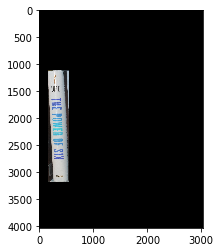

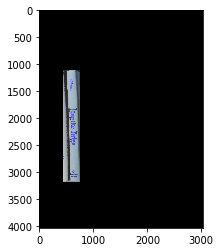

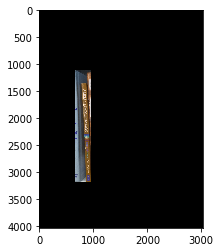

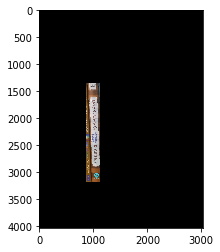

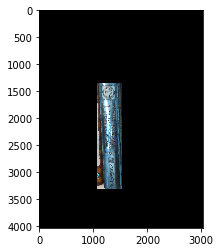

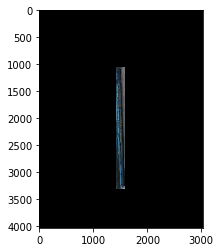

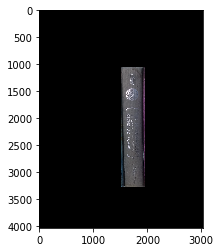

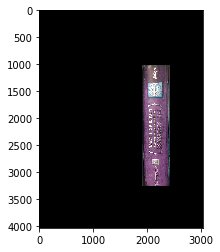

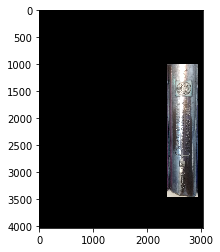

In [53]:

for x in rectangles:
    make_masks_for_text(img, x)

In [ ]:
# Functions that reads text off spine mask
        #print(text)
        text = google_api.detect_text(filename)
        #print(text)
        if text:
            dict_titles.setdefault(name, text)

In [ ]:
'''cv2.waitKey(0)
cropped = image[min_y:max_y,min_x:max_x]
resized = imutils.resize(cropped, height = 1000)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = cv2.threshold(gray, 0, 255,
               cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
filename = "{}_ind.png".format(os.getpid())
cv2.imwrite(filename, gray)
text  = pytesseract.image_to_string(Image.open(filename))

cropped = image[min_y:max_y,min_x:max_x]
        #remember height, then width
cv2.imshow(name, cropped)
        #cv2.waitKey(0)
        '''

In [ ]:
import io
import csv


def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
         content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    if len(texts) > 0:
        text = response.text_annotations[0].description
    else:
        text = None

    return text

gaussian blur


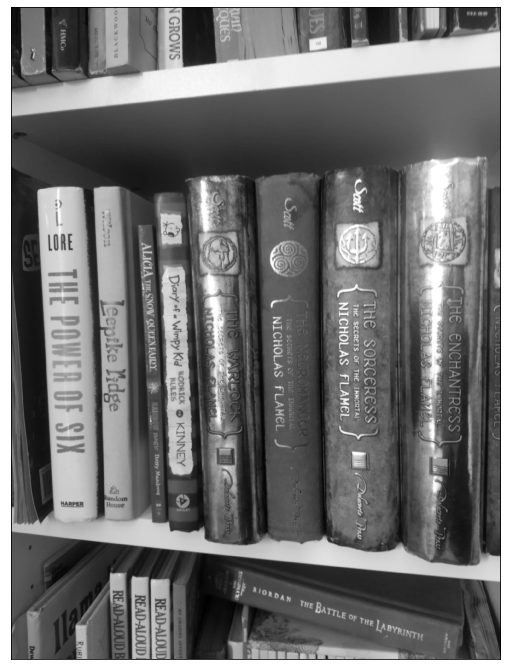

sobel x


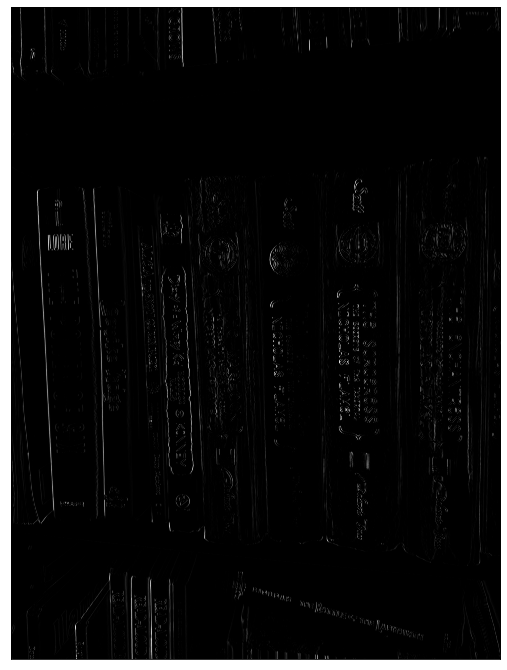

downsample 0


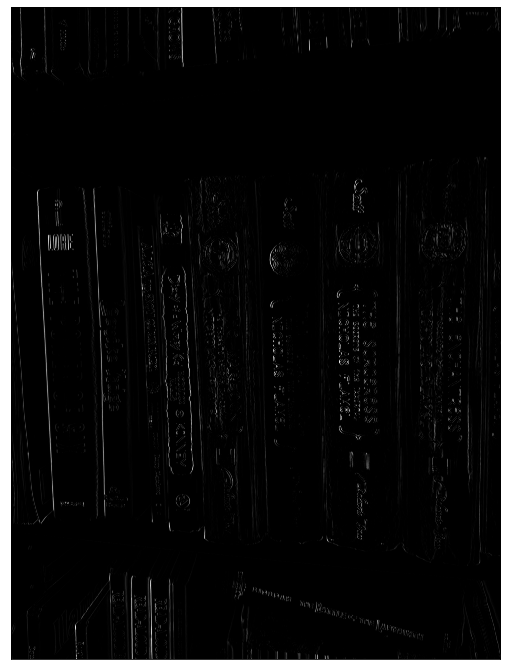

downsample 1


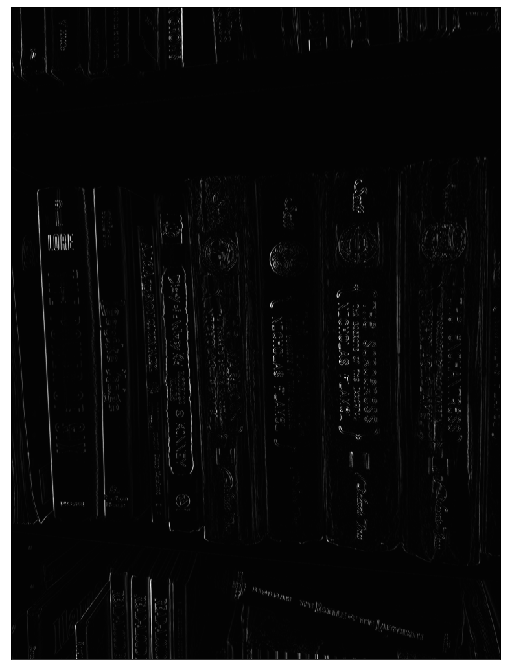

standardize


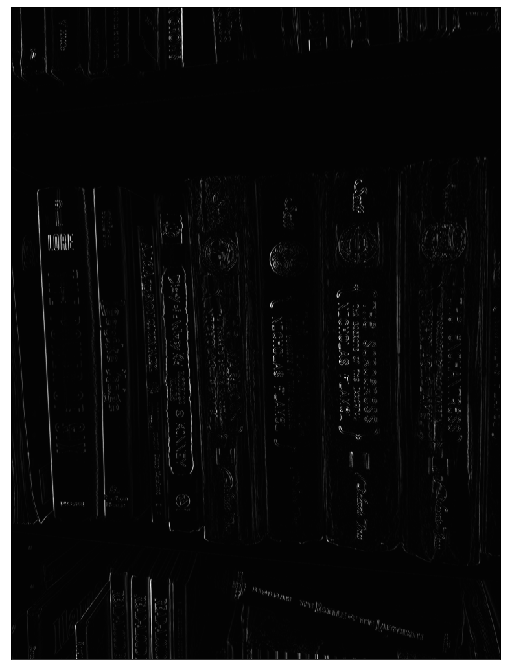

dynamic binarize (before)


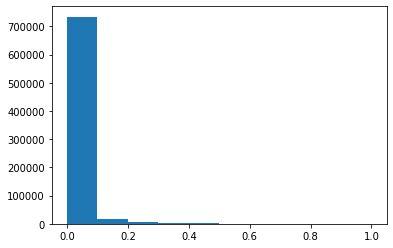

dynamic binarize


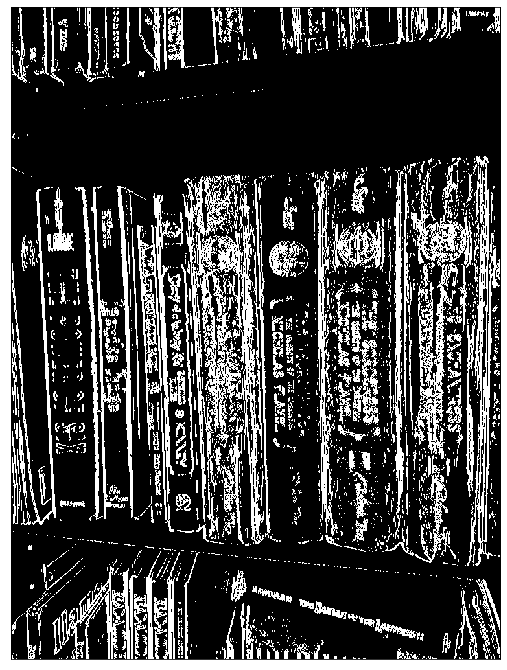

vertical erode


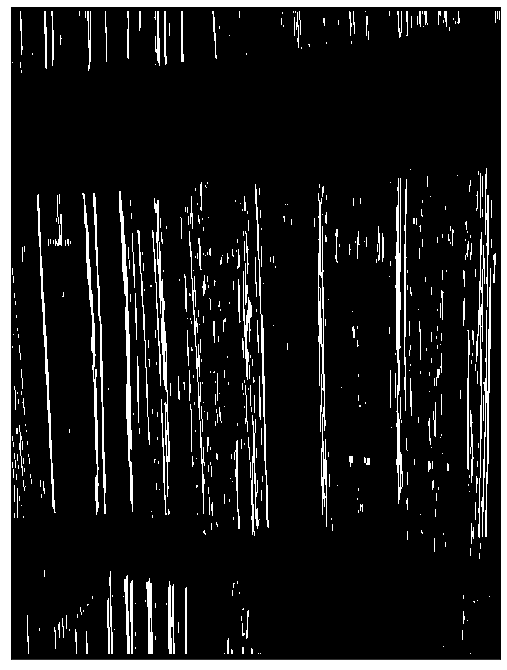

vertical dilate


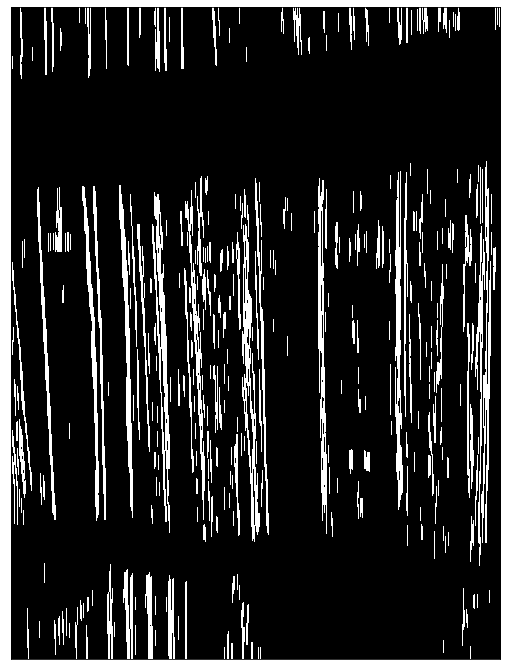

find connected components, levels =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

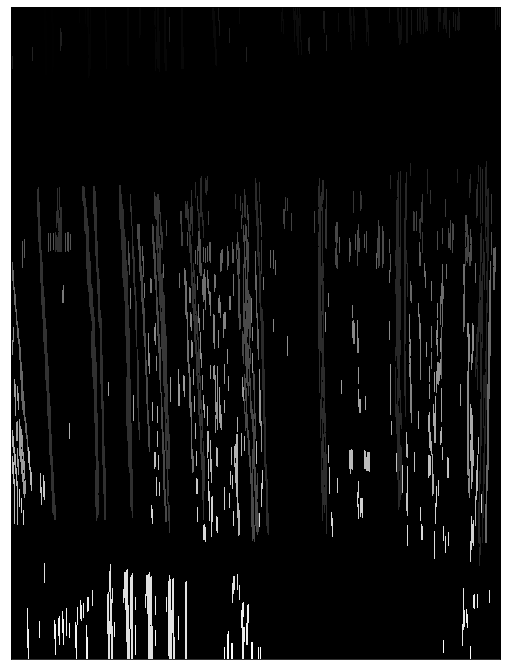

remove short clusters


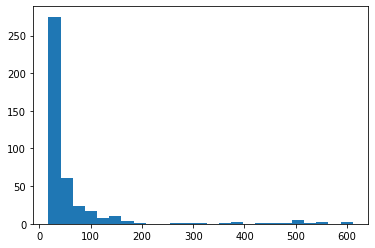

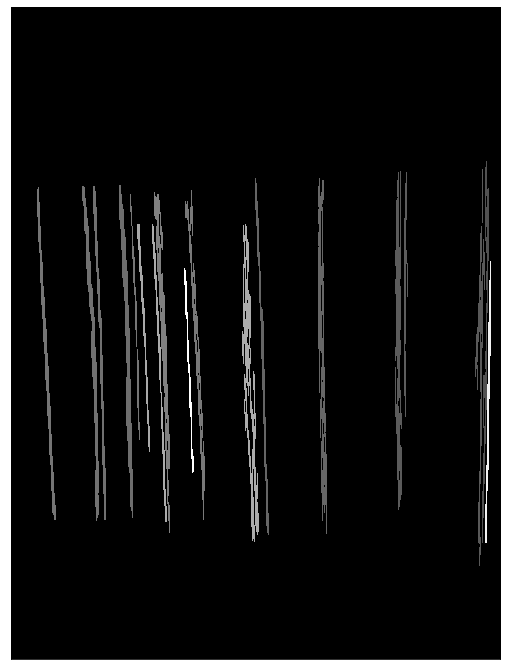

upsample


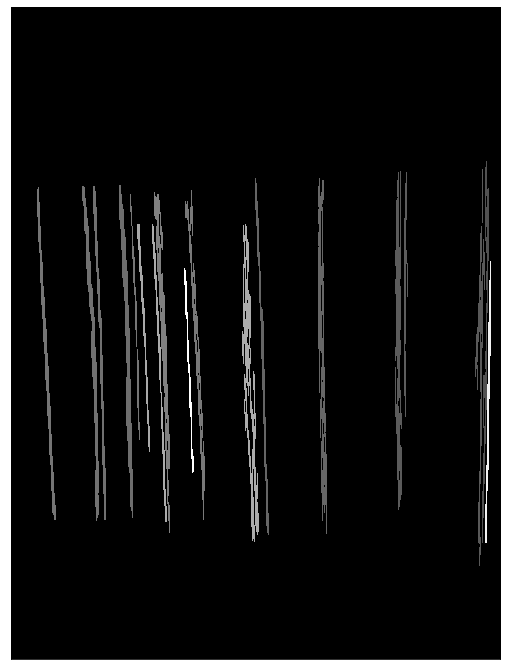

There are 9 books on this shelf


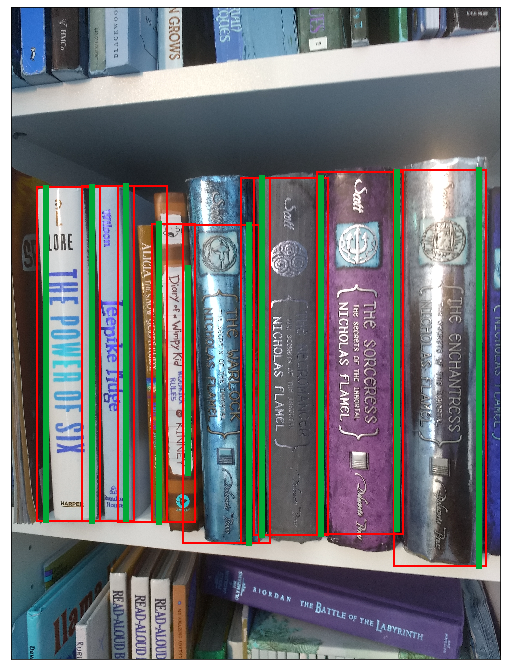

In [84]:
import cv2

img = cv2.imread('IMG_20190904_155939359.jpg')

booklines = get_book_lines(img,debug = True)

gaussian blur


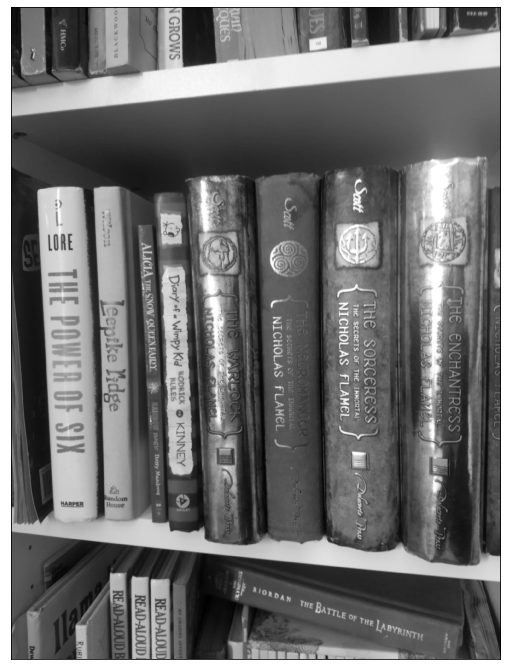

downsample 0


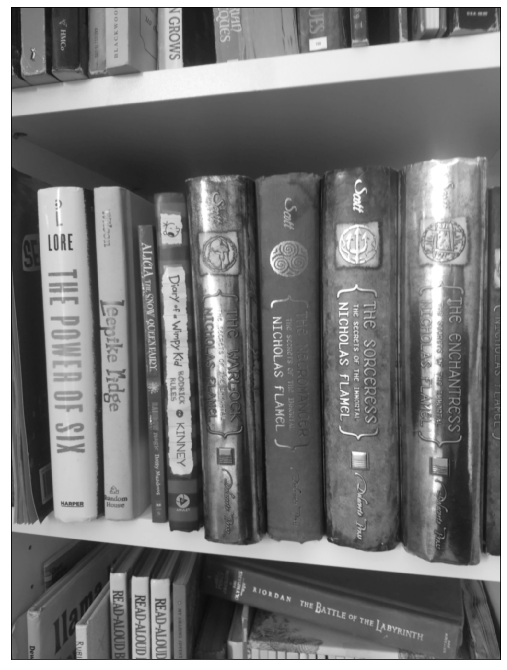

downsample 1


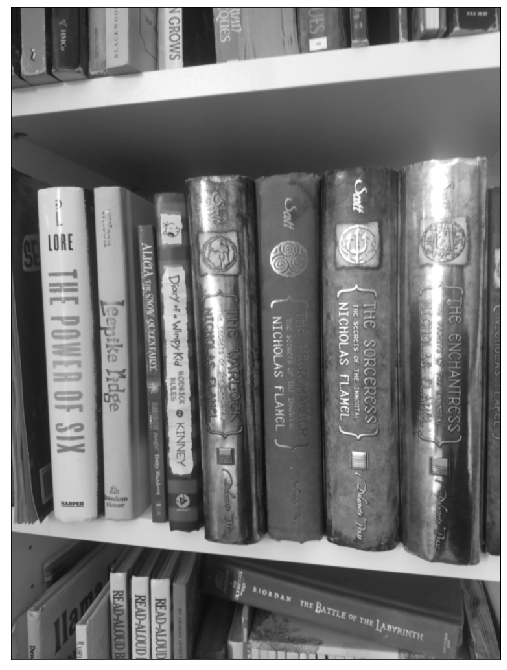

downsample 2


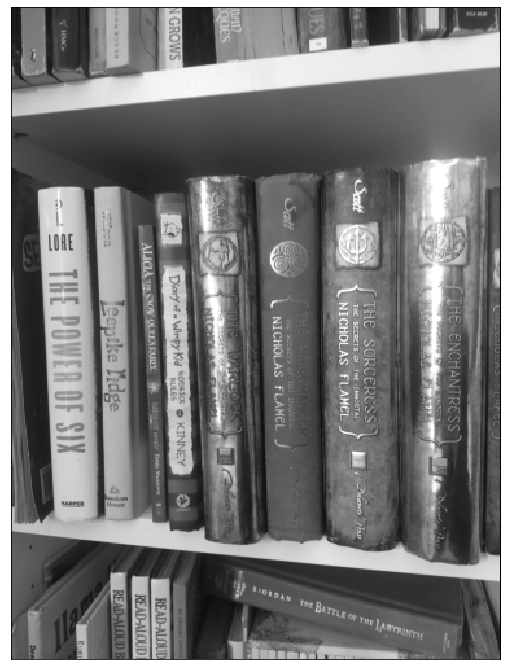

laplace squared


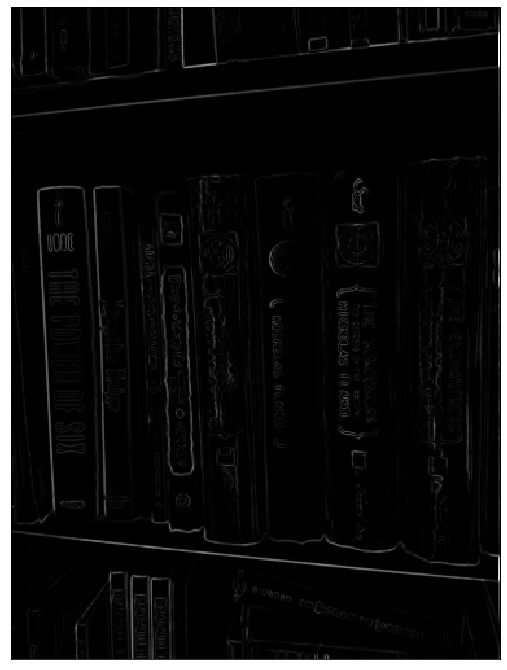

standardize


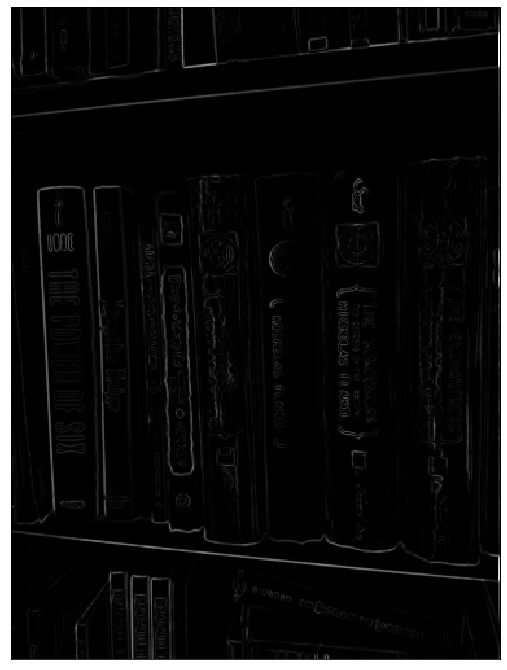

binarize


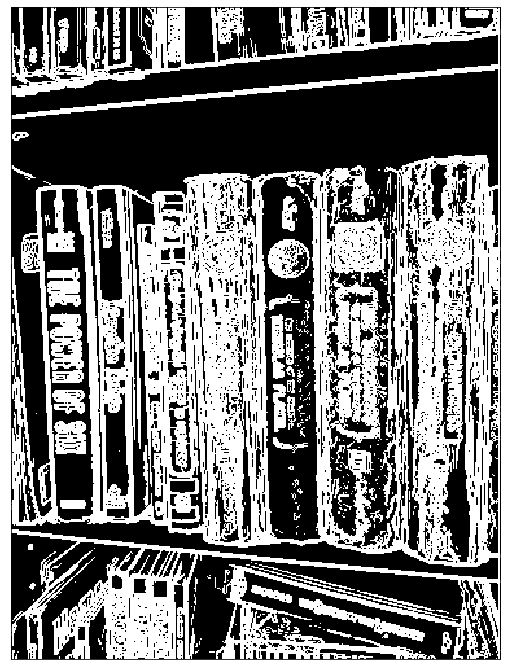

vertical dilate


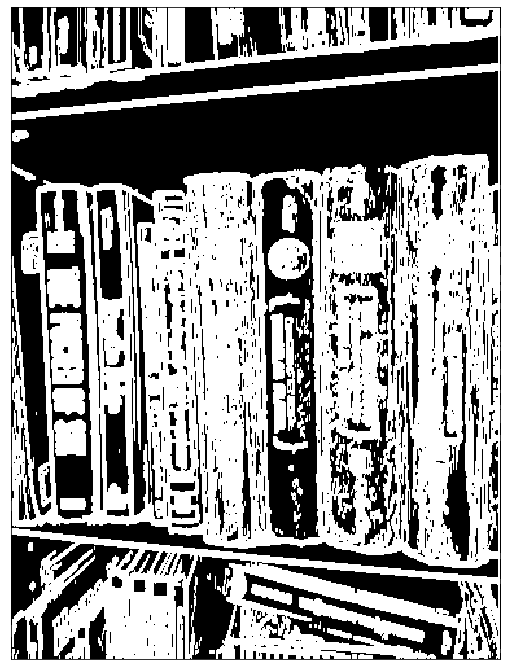

horizontal erode


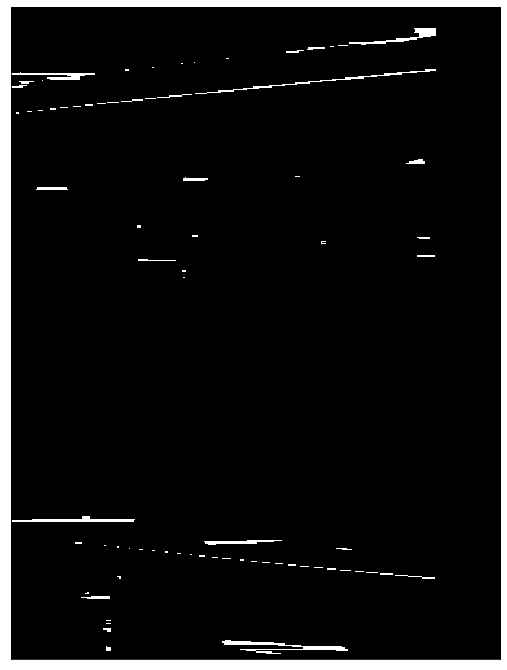

find connected components, levels =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


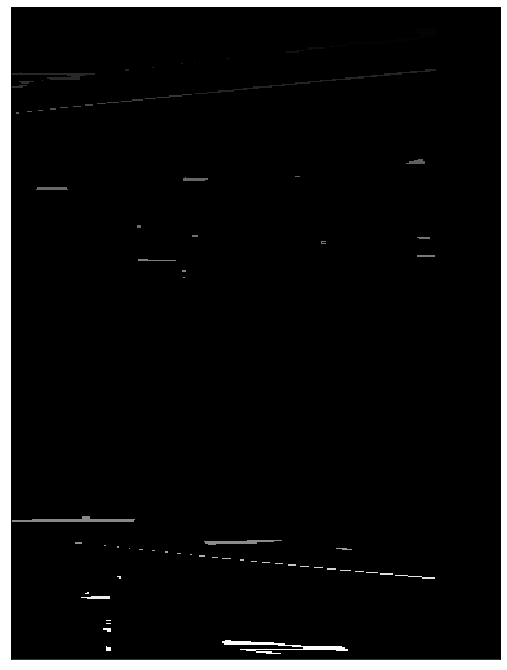

remove short clusters


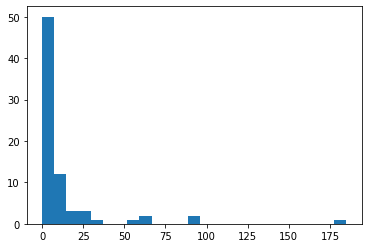

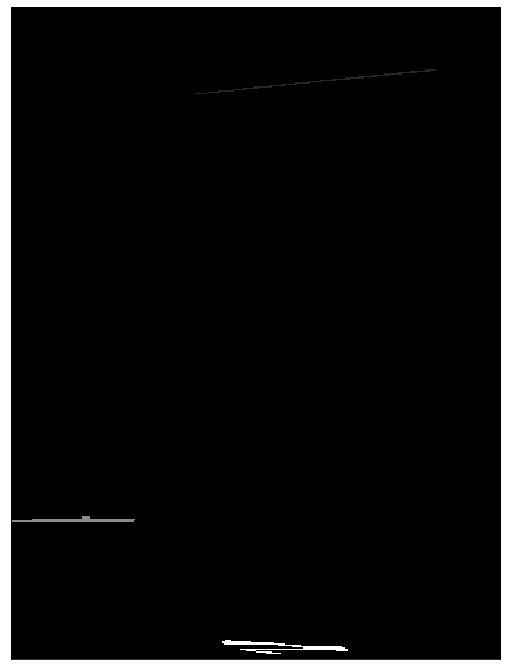

upsample


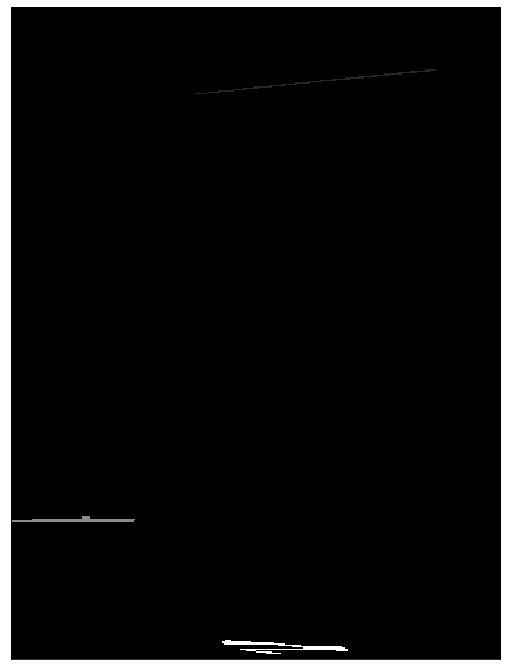

find connected components, levels =  [1, 2, 3]


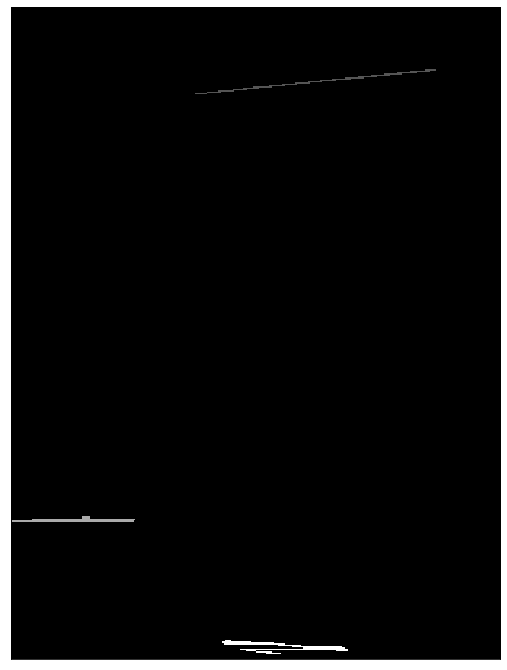

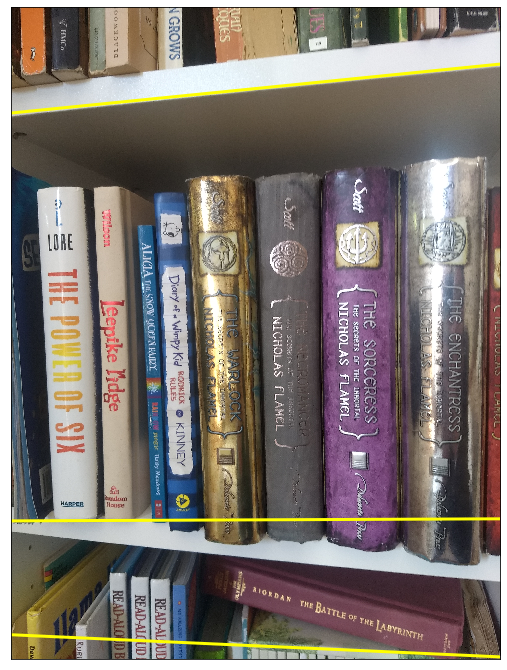

In [5]:
shelflines = get_shelf_lines(img,debug = True)

In [45]:
def distance_of_lines(lines):
    distance_btwn_lines = []
    for order, line in enumerate(lines):
        # print(type(line))
        # print(lines[order+1])
        line_x_cent, line_y_cent = line.center
        if line != lines[-1]:
            if lines[order+1].x(line_y_cent):
                distance_btwn_lines.append((lines[order+1].x(line_y_cent) - line.center[0]))
    return (distance_btwn_lines)

In [38]:
def distance_between_lines(line_one, line_two):
    line_x_cent, line_y_cent = line_one.center
    return line_two.x(line_y_cent) - line_x_cent

In [51]:
def take_first_line(lines):
    first_line = []
    for order, line in enumerate(lines):
        if order == 0:
            first_line.append(lines[order])
        if line != lines[-1]:
            distance = distance_between_lines(lines[order], lines[order+1])
            if distance > 75:
                first_line.append(lines[order+1])
            else:
                order +=2
                                 
    return first_line
                  

In [61]:
def find_rectangles(lines):
    lines.sort(key=lambda line: line.center[0])
    print("There are %d books on this shelf" % (len(lines)-1))

    rectangles = []
    
    for num, line in enumerate(lines):
        if line != lines[-1]:
            max_x = max(line.max_x, lines[num+1].max_x)
            min_x = min(line.min_x, lines[num+1].min_x)
            max_y = max(line.max_y, lines[num+1].max_y)
            min_y = min(line.min_y, lines[num+1].min_y)
            rectangles.append((min_x, min_y, max_x,max_y))
    return(rectangles)

In [62]:
find_rectangles(new_lines)

There are 9 books on this shelf


[(160, 1112, 543, 3179),
 (440, 1104, 751, 3179),
 (664, 1104, 959, 3183),
 (872, 1344, 1127, 3183),
 (1068, 1348, 1527, 3311),
 (1424, 1060, 1591, 3311),
 (1504, 1060, 1951, 3263),
 (1896, 1020, 2415, 3259),
 (2368, 1008, 2927, 3455)]